 ### Date: 26-May-2017 
### Approach: I used Random Forest Classifier for the over-sampled data set by SMOTE method
### AUC = 0.9
#### I identified the missing data, eliminated the redundant features and as we have more categorical data I used Random Forest approach. I re-sample the data using SMOTE approach and calculated not just AUC but also the area under precision-recall curve (used for imbalanced data set).

In [1]:
import numpy as np
import scipy 
import sklearn 
import matplotlib 
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt
from scipy import stats

# Data Analysis

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_train.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,is_male,device_type_num,outcome
0,56,0.005737,iPhone,M,0,62717,2,1,4,1,2,0
1,50,0.004733,desktop,F,0,64328,2,3,2,0,1,0
2,54,0.004129,laptop,M,0,83439,1,3,7,1,3,0
3,16,0.005117,Android,F,0,30110,2,3,0,0,0,0
4,37,0.003635,desktop,M,0,76565,2,1,5,1,1,0


In [3]:
df_train.shape

(10000, 12)

I need to make sure that in the "test" and "conversion" columns there are just 0 and 1 and the type is int. If there was Null, NA or any other number or character I need it to remove from dataset which is checked by type of the corresponding columns.  

In [4]:
np.where(pd.isnull(df_train)); # It shows the empty cells (NaN). In this case the gender column has all the NaN cells.

In [5]:
df_train["device_type"].value_counts()

desktop    2032
Android    2023
laptop     1991
other      1986
iPhone     1968
Name: device_type, dtype: int64

In [6]:
df_train["device_type_num"].value_counts()

1    2032
0    2023
3    1991
4    1986
2    1968
Name: device_type_num, dtype: int64

###### Comparing the two columns of "device_type" and "device_type_num" where both columns has the same meaning. So in training the model we can eliminate one of them.

In [7]:
df_train["outcome"].value_counts()

0    9018
1     982
Name: outcome, dtype: int64

#### The data set is imbalanced. We can start with that then try to upsample the data of "outcome = 1" or downsample the data of "outcome = 0".

In [8]:
df_test["is_male"].value_counts()

0    5155
1    4845
Name: is_male, dtype: int64

In [9]:
df_train.dtypes

age                             int64
cost_of_ad                    float64
device_type                    object
gender                         object
in_initial_launch_location      int64
income                          int64
n_drivers                       int64
n_vehicles                      int64
prior_ins_tenure                int64
is_male                         int64
device_type_num                 int64
outcome                         int64
dtype: object

#### I usually check the data type to make sure if the data in each column is consistent. For example, It is possible that the cell is not empty but instead of a value there is a "?". So, that will cause problem later.

In [10]:
df_train.describe()  # To have general idea how data is distributed w.r.t. different features

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,is_male,device_type_num,outcome
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.0000
mean,37.991800,0.004666,0.497500,58004.335800,1.497000,2.00220,5.406800,0.476100,1.988500,0.0982
std,13.038203,0.000838,0.500019,17330.778355,0.500016,0.81784,5.046014,0.499453,1.416322,0.2976
min,16.000000,0.003171,0.000000,16241.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.0000
25%,27.000000,0.003995,0.000000,45533.500000,1.000000,1.00000,1.000000,0.000000,1.000000,0.0000
50%,38.000000,0.004625,0.000000,58053.500000,1.000000,2.00000,4.000000,0.000000,2.000000,0.0000
75%,49.000000,0.005164,1.000000,70235.250000,2.000000,3.00000,8.000000,1.000000,3.000000,0.0000
max,60.000000,0.007082,1.000000,99956.000000,2.000000,3.00000,22.000000,1.000000,4.000000,1.0000


#### Eliminate the redundant columns so now we have 9 features and the modified data frame is : df_train_mod

In [11]:
# df.drop('column_name', axis=1, inplace=True) # To delete the column without having to reassign df / axis = 1 for columns, axis = 0 for rows
# df = df.drop('column_name', 1)
df_train_mod = df_train.drop(df_train.columns[[2, 3]], axis=1);  # df.columns is zero-based pd.Index 
df_train_mod.head(1)

,age,cost_of_ad,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,is_male,device_type_num,outcome
0,56,0.005737,0,62717,2,1,4,1,2,0


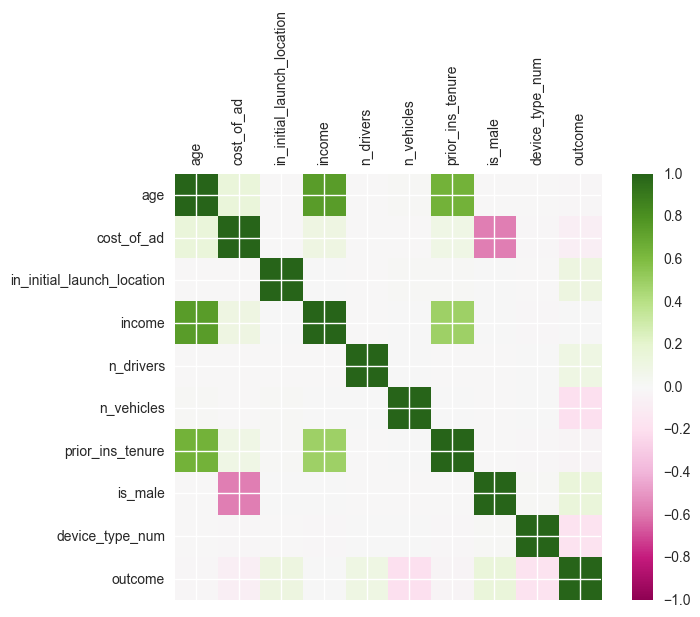

In [12]:
# Compute the correlation matrix
corr = df_train_mod.corr()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr, vmin=-1, vmax=1, cmap=plt.cm.PiYG)
fig.colorbar(cax)
ticks = np.arange(0,10,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
names = list(df_train_mod.columns.values)
ax.set_xticklabels(names,rotation='vertical')
ax.set_yticklabels(names)
plt.show()
%matplotlib inline

#### It can be seen that there is a strong correlation age and income, prior_ins_tenure. And reverse relation between is_male and cost_of_ad. By being male the cost_of_ad is decreasing. This plot gives an idea about the relations between features. 

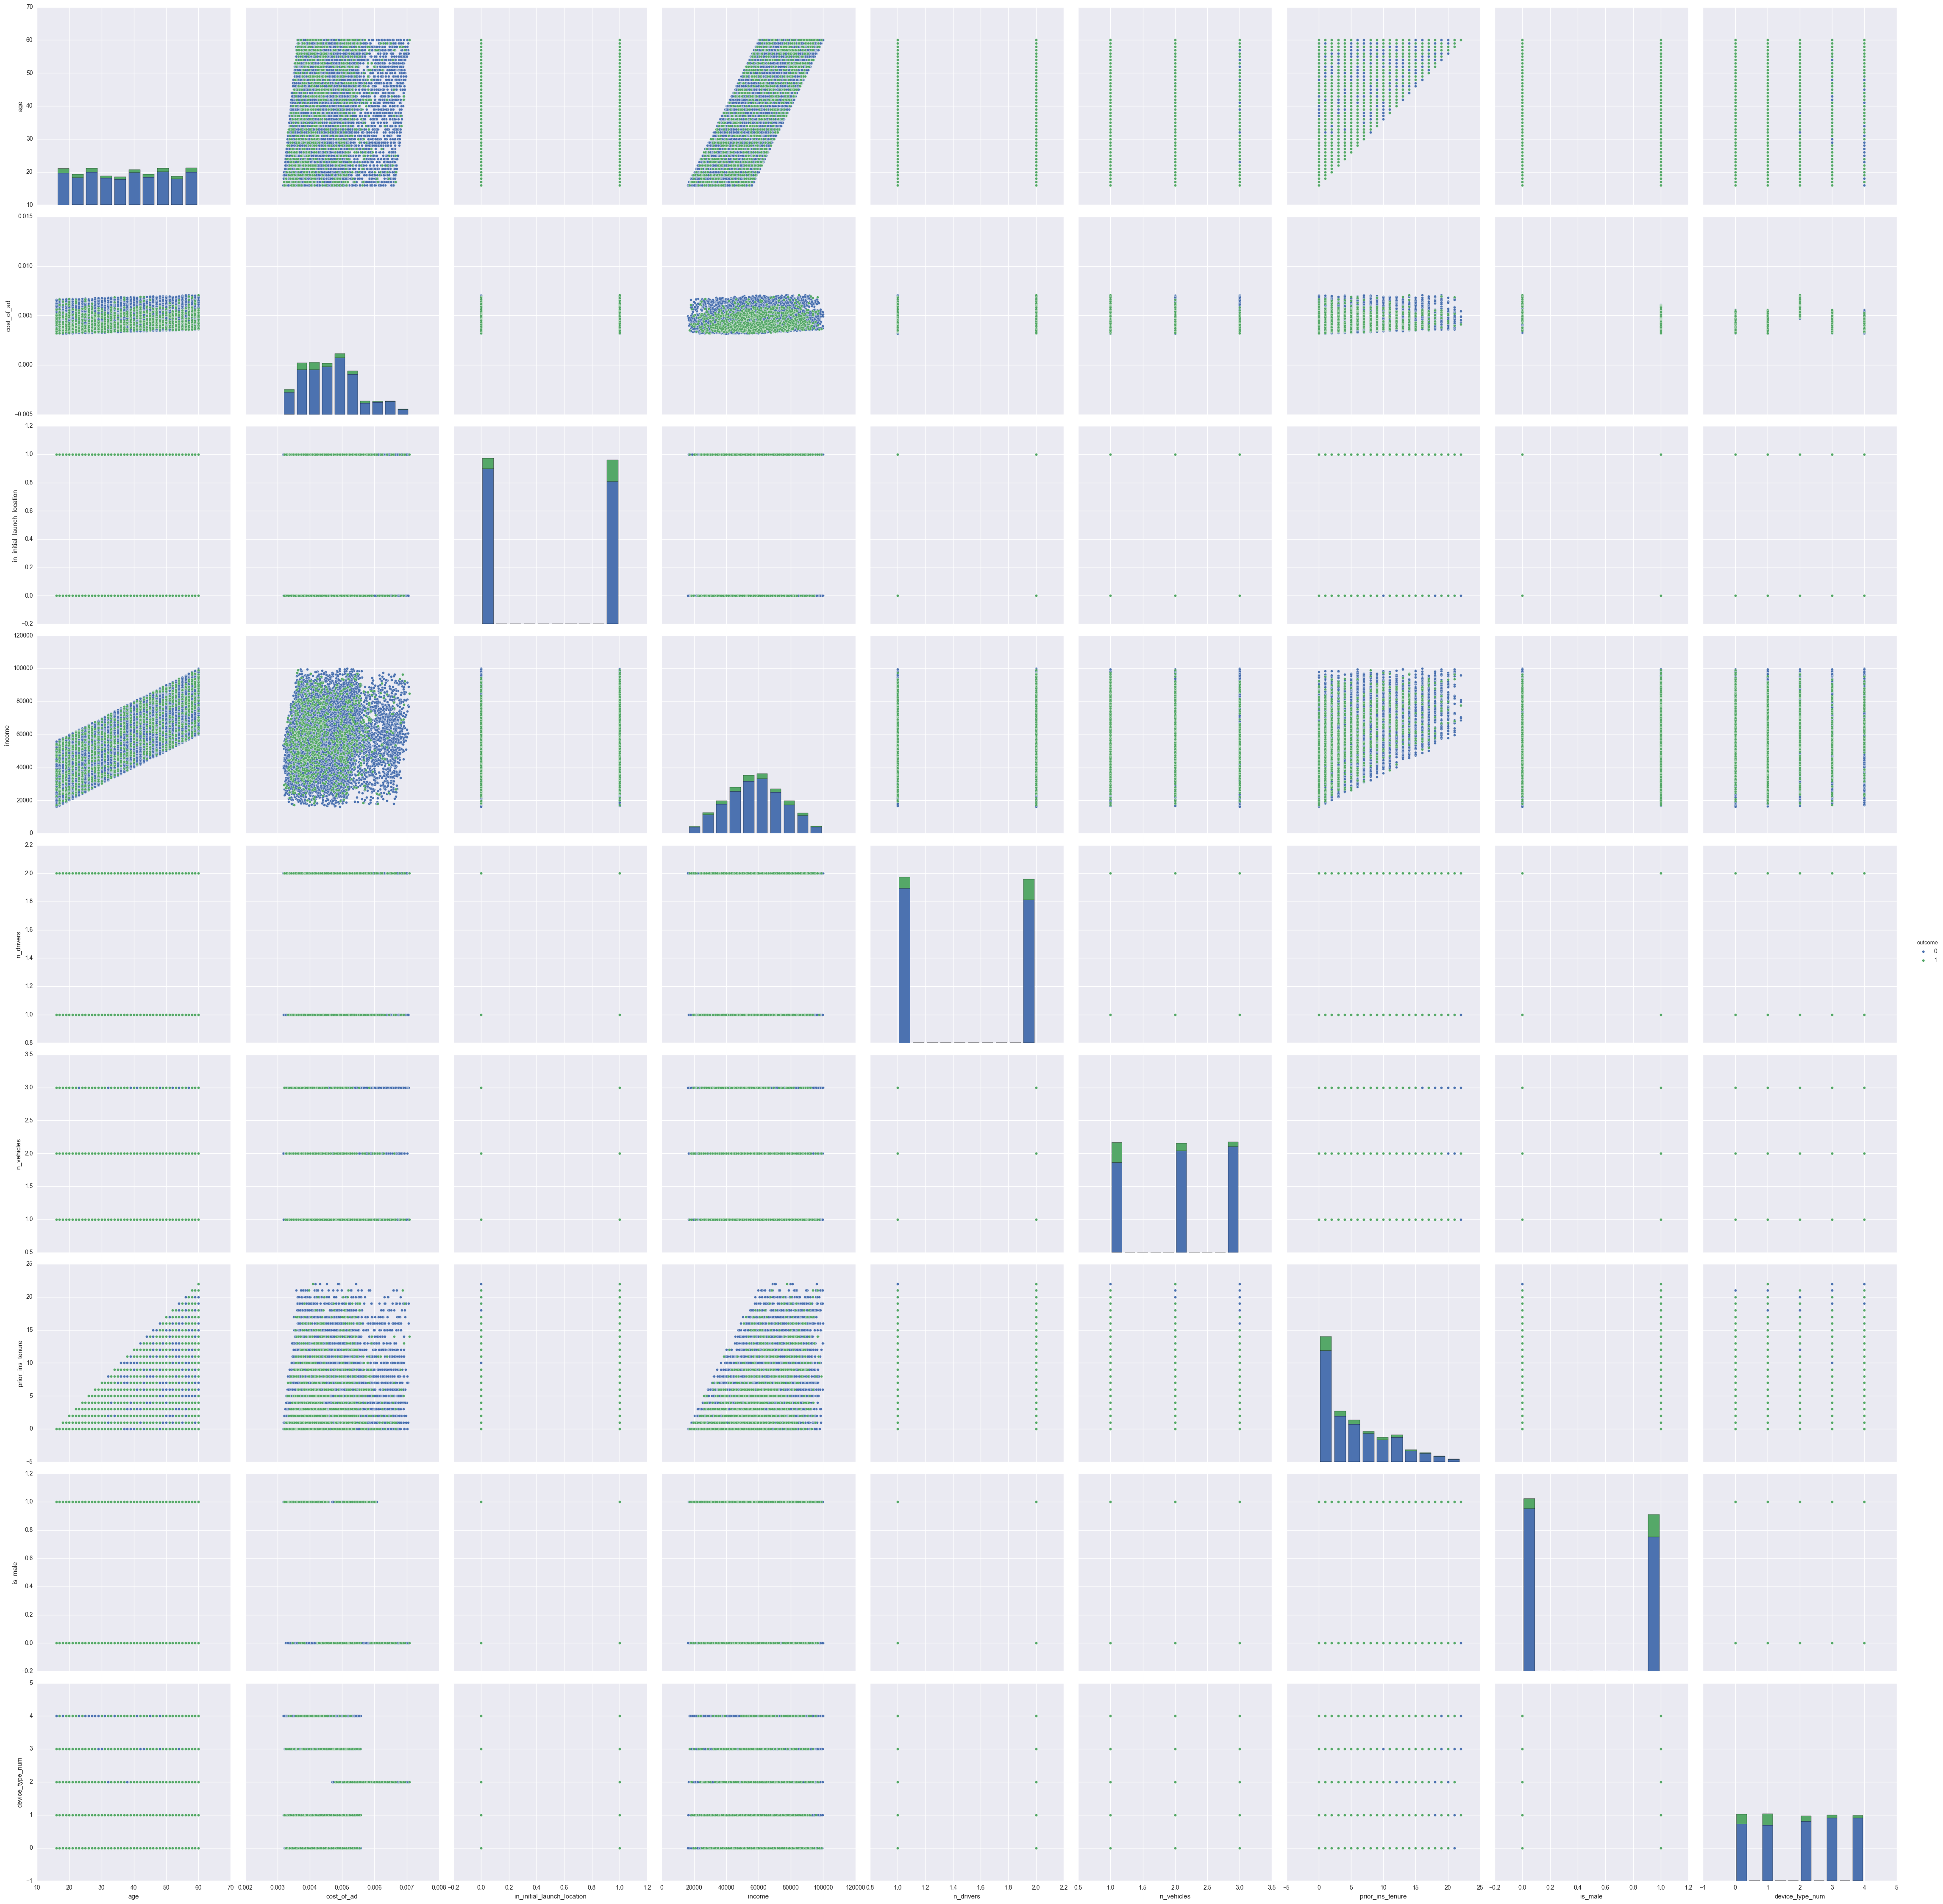

In [13]:
sns.pairplot(vars=["age","cost_of_ad","in_initial_launch_location","income","n_drivers","n_vehicles",
                   "prior_ins_tenure","is_male","device_type_num"], data=df_train_mod, hue="outcome", size=5)
# To see in details, click on the plot

#### Feature Extraction: Looking into the importance of the features 

In [14]:
# feature extraction
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
arrayform = df_train_mod.values
X = arrayform[:,0:9]
Y = arrayform[:,9]
model.fit(X, Y)
print(model.feature_importances_)

[ 0.18692266  0.21270175  0.04327671  0.19433902  0.0334413   0.06443218
  0.13726034  0.03197613  0.09564992]


#### Split the training set into train and test (I choose 30% for testing my model to evaluate the possible AUC)

In [15]:
from sklearn.model_selection import train_test_split

arrayform = df_train_mod.values
X = arrayform[:,0:9]
Y = arrayform[:,9]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

#### Random Forest (In a case of using imbalanced data set --> Check the precision and recall of minority class)

In [16]:
from sklearn.ensemble import RandomForestClassifier
# Create a random forest classifier. By convention, clf means 'classifier'
clf = RandomForestClassifier(n_jobs=2)

# Train the classifier to take the training features and learn how they relate
# to the training y (the species)
clf.fit(X_train, y_train);

In [17]:
from sklearn import metrics
print metrics.classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

        0.0       0.91      0.99      0.95      2694
        1.0       0.61      0.19      0.29       306

avg / total       0.88      0.91      0.88      3000



#### Resampling the data (I used the ratio of 50% = (Minority Class Population)/(Majority Class Population)). Increasing this rate will give us the higher AUC.

> Regarding the over-sampling of the data or using SMOTE approach you need to install the "imbalanced-learn package"

> Here is the command to do it: conda install -c glemaitre imbalanced-learn

In [18]:
# conda install -c glemaitre imbalanced-learn
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(ratio=0.5, random_state=42) 
X_resampled_auto, y_resampled_auto = ros.fit_sample(X, Y)

In [19]:
y_resampled_auto.shape

(13527,)

In [20]:
X_train_re, X_test_re, y_train_re, y_test_re = train_test_split(X_resampled_auto, y_resampled_auto, test_size=0.3, random_state=20)
clf_re = RandomForestClassifier(n_jobs=2)
clf_re.fit(X_train_re, y_train_re);

print metrics.classification_report(y_test_re, clf_re.predict(X_test_re))

             precision    recall  f1-score   support

        0.0       0.98      0.94      0.96      2713
        1.0       0.89      0.97      0.93      1346

avg / total       0.95      0.95      0.95      4059



##### AUC value

In [21]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_re, clf_re.predict(X_test_re), pos_label=1)
metrics.auc(fpr, tpr)

0.95601922721977561

##### Area under the Precision-Recall Curve (This is used for imbalanced data set)

In [22]:
from sklearn.metrics import average_precision_score
average_precision_score(y_test_re, clf_re.predict(X_test_re))  

0.93643210266576782

#### Resampling using SMOTE method

In [23]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(ratio= 0.5, random_state=42)
X_res, y_res = sm.fit_sample(X, Y)

In [24]:
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_res, y_res, test_size=0.3, random_state=20)
clf_sm = RandomForestClassifier(n_jobs=2)
clf_sm.fit(X_train_sm, y_train_sm);

print metrics.classification_report(y_test_sm, clf_sm.predict(X_test_sm))

             precision    recall  f1-score   support

        0.0       0.92      0.97      0.94      2689
        1.0       0.94      0.82      0.88      1370

avg / total       0.92      0.92      0.92      4059



In [25]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_sm, clf_sm.predict(X_test_sm), pos_label=1)
metrics.auc(fpr, tpr)

0.89846305440114227

In [26]:
average_precision_score(y_test_sm, clf_sm.predict(X_test_sm))  

0.91085235917683649

### Load Test data set

In [27]:
df_test = pd.read_csv('test.csv')
df_test.head()

,age,cost_of_ad,device_type,gender,in_initial_launch_location,income,n_drivers,n_vehicles,prior_ins_tenure,is_male,device_type_num
0,34,0.005134,Android,F,1,40376,1,3,7,0,0
1,53,0.005223,desktop,F,1,84511,1,1,11,0,1
2,46,0.004939,laptop,F,0,79322,1,1,4,0,3
3,36,0.004924,Android,F,0,63295,1,2,0,0,0
4,28,0.005146,other,F,1,36170,1,3,3,0,4


In [28]:
df_test.shape

(10000, 11)

In [29]:
df_test_mod = df_test.drop(df_test.columns[[2, 3]], axis=1);
arrayform_test = df_test_mod.values
X_testdata = arrayform_test[:,0:9]

In [30]:
y_test_prediction = clf_sm.predict(X_testdata)

In [31]:
from collections import Counter
Counter(y_test_prediction)

Counter({0.0: 9501, 1.0: 499})

In [32]:
y_test_prediction

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])